# Explore here

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, f1_score, 
                            roc_auc_score, confusion_matrix, 
                            ConfusionMatrixDisplay, classification_report)

In [39]:
url = 'https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv'

data = pd.read_csv(url)

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [40]:
print(f"\n📊 Dimensiones del dataset: {data.shape}")
print("\n🔍 Primeras filas:")
print(data.head())
print("\n📝 Resumen estadístico:")
print(data.describe())
print("\n🎯 Distribución de clases:")
print(data['Outcome'].value_counts(normalize=True))


📊 Dimensiones del dataset: (768, 9)

🔍 Primeras filas:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

📝 Resumen estadístico:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.79947

In [41]:
X = data.drop(["Outcome"], axis = 1)
y = data["Outcome"]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [43]:
base_model = RandomForestClassifier(n_estimators=100, random_state=42)
base_model.fit(X_train, y_train)
y_pred_base = base_model.predict(X_test)
print(f"\n⚡ F1-score (Modelo Base): {f1_score(y_test, y_pred_base):.4f}")


⚡ F1-score (Modelo Base): 0.6337


In [44]:
param_grid = {
    'n_estimators' :[50, 100, 200],
    'max_depth' :[5, 10, 20, None],
    'min_samples_split' :[2, 5, 10],
    'min_samples_leaf' :[1, 2, 4],
}

grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='f1', n_jobs=1, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, 

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=1,
             param_grid={'max_depth': [5, 10, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='f1', verbose=2)

In [45]:
results = pd.DataFrame(grid_search.cv_results_)
print("\n🏆 Mejores parámetros encontrados:")
print(grid_search.best_params_)


🏆 Mejores parámetros encontrados:
{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [46]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]


In [47]:
print("\n📈 Métricas Finales:")
print(f"🔹 F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"🔹 Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"🔹 AUC: {roc_auc_score(y_test, y_proba):.4f}")


📈 Métricas Finales:
🔹 F1-score: 0.6000
🔹 Accuracy: 0.7403
🔹 AUC: 0.8202


In [48]:
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Diabetes", "Diabetes"]))


📊 Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.78      0.84      0.81       100
    Diabetes       0.65      0.56      0.60        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.74      0.73       154



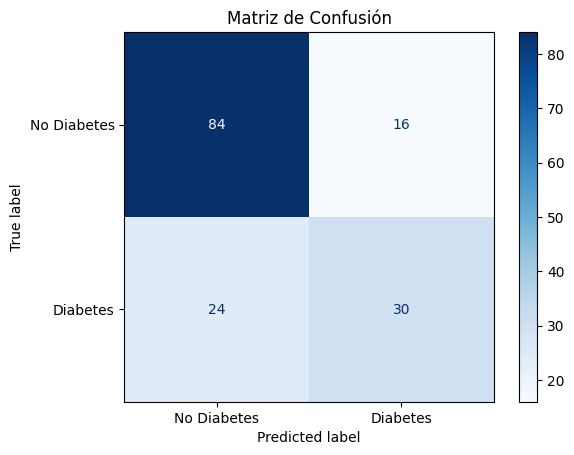

In [49]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Diabetes"])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

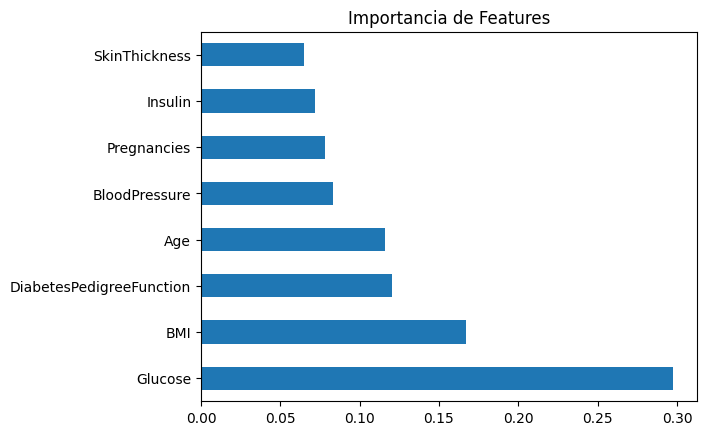

In [50]:
importances = best_model.feature_importances_
feature_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
feature_imp.plot(kind='barh', title='Importancia de Features')
plt.show()